In [3]:
%load_ext autoreload
%autoreload 2
import torch

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets.EmergencyDataset import EmergencyDataset

audio_set_val = Audioset(split_mode='validation', fixed_padding=True)
emergency_set_val = EmergencyDataset('val')

NameError: name 'Audioset' is not defined

In [16]:
from classification.models.M5 import M5
loaded_dict = torch.load("/nfs/homedirs/herrmanp/project-4/experiments/notebooks/pascal/adv_totaly_hig_50epochs.pt")
model = M5(loaded_dict["hparams"])
model.load_state_dict(loaded_dict["state_dict"])
model.cuda()

In [19]:
from classification.models.SpectrogramCNN import SpectrogramCNN

state_dict_path = '/nfs/students/summer-term-2020/project-4/data/models/SpectrogramBasedCNN.pt'

model = SpectrogramCNN()
model.load_state_dict(torch.load(state_dict_path))
model = model.cuda()
model = model.eval()

## Exhaustive experiment

In [21]:
from attacks.fgsm import FGSM
from tqdm import tqdm

a = 0
b = 2
step_size = 0.02
print(f"Iterations: {len(torch.arange(a, b, step_size))}")

attacks = []

for eps in tqdm(torch.arange(a, b, step_size)):
    valid_loader = DataLoader(audio_set_val, batch_size=1)
    attack_parameters = {'epsilon': eps}

    fgsm = FGSM(model, valid_loader, attack_parameters)
    fgsm.attack()
    attacks.append(fgsm)

  0%|          | 0/100 [00:00<?, ?it/s]

Iterations: 100


100%|██████████| 100/100 [56:52<00:00, 34.12s/it]


In [23]:
from utils.Visual import drawPlot

In [ ]:
import pickle
save_path = "/nfs/students/summer-term-2020/project-4/data/attacks/spectrogramCNNmodelFGSMattack.p"
pickle.dump(attacks, open( save_path, "wb" ) )

/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


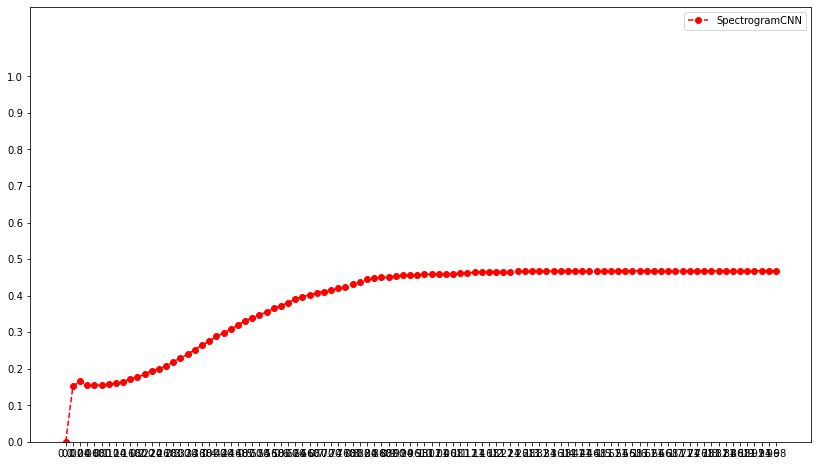

In [25]:
import numpy as np

spacing = [round(x,2) for x in np.arange(a, b, step_size)]
successRates = []

for attack in attacks:
    successRates.append(attack.getSuccessRate())
    
drawPlot(spacing, [{"data": successRates, 'color': 'r', 'label': 'SpectrogramCNN'}])